# 1) Setup

## 1a) Library functions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from datetime import datetime, timedelta
from copy import copy

#sklearn
from sklearn.model_selection import train_test_split
import sklearn as skl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

#Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

# Set random seed for reproducability
#tensorflow.random.set_seed(0)

print("done")

done


## 1b) Helper functions

In [2]:
def ListUnion(l1, l2):
    union = list(set(l1) | set(l2))
    return union

In [3]:
def regression_analysis(X,Y):
    #remove nans
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
    X = X[~np.isnan(X)]
    Y = Y[~np.isnan(X)]
    
    #fit OLS
    X2 = sm.add_constant(X)
    model = sm.OLS(Y, X2).fit() ## sm.OLS(output, input)
    coeff = [model.params[1],model.params[0]]
    
    #correlation
    corr = sp.stats.pearsonr(X,Y)
    
    #plot
    plt.scatter(X,Y,marker = ".");
    x_plot = np.arange(X.min(),X.max(),0.01)
    plt.plot(x_plot,np.polyval(coeff,x_plot),color = "orange");
    plt.xlabel("Return for index")
    plt.ylabel("Return for our strategy")
    #title = "alpha = %.5f  |  beta = %.5f, \n pval_alpha = %.5f  |  correlation = %.5f" % (model.params[0],model.params[1],model.pvalues[0],corr[0])
    title = "alpha = %.5f  |  beta = %.5f  |  corr = %.5f" % (model.params[0],model.params[1],corr[0])
    plt.title(title)
    return;


In [4]:
def get_TrainTest(df_train,df_test,features, target, is_regression = True):
    """
    Get Train & Test matrices in correct format
    """
    x_train = df_train[features].values
    y_train = df_train[target].values
    x_test = df_test[features].values
    y_test = df_test[target].values

    #set data types
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train =y_train.astype('float32')
    y_test = y_test.astype('float32')

    #change data type if classification
    if is_regression == False:
        y_train = y_train > 0  #classification
        y_test = y_test > 0    #classification
        y_train = utils.to_categorical(y_train)
        y_test = utils.to_categorical(y_test)
    print ('Training Set: %d, Test Set: %d \n' % (len(x_train), len(x_test)))
    return x_train, y_train, x_test, y_test

In [5]:
def create_NN(hidden, dropout, input_dim, is_regression = True, std =  0.01, seed = 1):
    """
    Create MLP regression / classifier with random initialisation, Batch Normalisation & dropout
    """
    if len(hidden) != len(dropout):
        raise ValueError("Incompatible sequence lengths for hidden & dropout")
    model = Sequential()
    #input layer
    model.add(Dense(hidden[0], input_dim=input_dim, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #hidden layers
    for i in range(1,len(hidden)):
        model.add(Dense(hidden[i], input_dim=hidden[i-1], activation='relu',kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout[i]))
    #output layer
    if is_regression:
        model.add(Dense(1, input_dim=hidden[-1], activation=None,kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    else:
        model.add(Dense(2, input_dim=hidden[-1], activation="softmax",kernel_initializer=initializers.RandomNormal(stddev=std, seed = seed)))
    return model
    

In [6]:
def train_NN(model, x_train, y_train, x_test, y_test, learning_rate = 0.1, is_regression = True, num_epochs = 50, plot_graph = False):
    """
    Train NN with Adam optimiser
    """
    #create optimiser
    opt = optimizers.Adam(learning_rate=learning_rate)
    if is_regression:
        loss_fn = keras.losses.MeanSquaredError()
    else:
        loss_fn = keras.losses.CategoricalCrossentropy()
    model.compile(loss=loss_fn,
                  optimizer=opt,
                  metrics=[loss_fn])
    #fit model
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=500, validation_data=(x_test, y_test), verbose = 0)

    #plot fitting results
    if plot_graph:
        epoch_nums = range(1,num_epochs+1)
        training_loss = history.history["loss"]
        validation_loss = history.history["val_loss"]
        plt.plot(epoch_nums, training_loss)
        plt.plot(epoch_nums, validation_loss)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['training', 'validation'], loc='upper right')
        plt.show()
    
    return model, history

In [7]:
def get_Matrices(model, x_test, df_test, company_name = "TICKER", is_regression = True, pct = 0.1, is_short = False):
    """
    create return & weight matrices
    """
    # predict outputs
    model_output = model.predict(x_test)
    if is_regression == False:
        model_output = model_output[:,1]
    #map to original test dataframe for price data
    predictions = df_test.iloc[:,:5]
    predictions["pred"] = model_output
    
    #rank predictions
    predictions["rank"] = predictions.groupby("month")["pred"].rank("dense", ascending = False)
    rank_table = pd.pivot_table(predictions, values="rank", index=["month"],
                    columns=[company_name])
    
    #create weight matrix
    weight_matrix = pd.DataFrame(index = rank_table.index, columns = rank_table.columns, data = 0)
    weight_matrix[rank_table.lt(np.floor(pct*rank_table.max(axis = 1))+1, axis = 0)] = 1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    # include shorts
    if is_short:
        weight_matrix[rank_table.gt(np.floor((1-pct)*rank_table.max(axis = 1))+1, axis = 0)] = -1/np.transpose(np.tile(np.floor(rank_table.max(axis = 1)*pct),(len(rank_table.columns),1)))
    
    #create returns matrix
    returns_matrix = pd.pivot_table(predictions, values="pred_target", index=["month"],
                    columns=[company_name])
    return returns_matrix, weight_matrix, rank_table, model_output

In [8]:
def turnover_cost(w, k):
    """
    Calculate transaction costs. k is in bps, w is a weight matrix
    """
    k = k/10000  #convert to bps
    w.fillna(value = 0, inplace=True)
    return w.diff(1).abs().sum(axis = 1) * k

In [9]:
def calc_returns(returns_matrix, weight_matrix, k = 3):
    """
    Calculate returns & cumulative returns, including transaction costs of k bps.
    """
    #equal weighted
    if isinstance(weight_matrix,str):
        if weight_matrix == "equal":
            rets = returns_matrix.mean(axis = 1)
            rets.index = rets.index.to_timestamp()   #convert periods to timestamps
            cumrets = (1+rets).cumprod()
        else:
            raise ValueError("Invalid string argument. Must be equal")
    else:
        #calculate returns using weight matrix
        rets = (weight_matrix*returns_matrix.fillna(0)).sum(axis = 1)
        rets = rets - turnover_cost(weight_matrix, k)
        rets.index = rets.index.to_timestamp()   #convert periods to timestamps
        #calculate cumulative returns
        cumrets = (1+rets).cumprod()
    return rets, cumrets

In [10]:
def calc_sharpe(rets):
    n = len(rets)/12
    cumrets = (1+rets).cumprod()
    sharpe = (cumrets[-1]**(1/n) - 1)/(np.std(rets) * np.sqrt(12))
    return sharpe

In [11]:
def feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=1, is_regression = True):
    if is_regression:
        scoring =  "neg_mean_squared_error"
    else:
        #neg_log_loss is technically correct, but not worth rewriting permutation importance to replace predict_proba with predict
        #scoring = "neg_log_loss"
        scoring =  "neg_mean_squared_error"
    result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, random_state=random_state, scoring = scoring)
    sorted_idx = result.importances_mean.argsort()
    labels = np.array(features)

    plt.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=labels[sorted_idx]
    )
    plt.title("Permutation Importances (test set)")

    plt.tight_layout()
    plt.xticks(rotation = 45)
    plt.show()
    
    features_pi = list(labels[result.importances_mean > 0])
    print("Permutation importance > 0:")
    print(features_pi)
    return result, features_pi

## 1c) Read data

In [12]:
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_fillna.pkl")
#df_nn = pd.read_pickle("df_NeuralNetworkFeatures_bloomberg.pkl")
df_nn = pd.read_pickle("df_NeuralNetworkFeatures.pkl")
df_nn

,TICKER,month,pred_target,price_adjusted,mcap,debt_assets,de_ratio,evm,pe_exi,roe,...,Unemployment,MEDPTG,PCTUP4W,PCTDOWN4W,volume,return_1M,return_3M,return_6M,return_9M,return_12M
688,SUNW,2006-02,-0.173913,1150.00,3.234794e+10,0.537,1.158,31.570,-166.800,-0.049,...,4.8,3.755182e-125,0.111111,0.111111,74.750154,0.009367,0.023967,0.047332,0.068906,0.094519
689,SUNW,2006-03,0.047368,950.00,3.234794e+10,0.537,1.158,31.570,-205.200,-0.049,...,4.7,1.946951e-103,0.111111,0.000000,0.391174,-0.173913,0.023967,0.047332,0.068906,0.094519
690,SUNW,2006-04,-0.120603,995.00,3.170707e+07,0.537,1.158,31.570,-200.000,-0.049,...,4.7,2.532457e-108,0.200000,0.000000,-0.671308,0.047368,0.023967,0.047332,0.068906,0.094519
691,SUNW,2006-05,0.000000,875.00,2.788310e+07,0.543,1.188,36.801,-123.470,-0.078,...,4.6,2.269322e-73,0.500000,0.000000,1.051449,-0.120603,-0.239130,0.047332,0.068906,0.094519
692,SUNW,2006-06,-0.200000,875.00,2.788310e+07,0.543,1.188,36.801,-110.670,-0.078,...,4.6,2.269322e-73,0.222222,0.111111,-0.780028,0.000000,-0.078947,0.047332,0.068906,0.094519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209711,CBOE,2020-07,0.046636,87.70,9.622444e+09,0.351,0.541,14.910,22.430,0.117,...,10.2,1.140747e+00,0.000000,0.500000,-0.163128,-0.059820,-0.117529,-0.288265,-0.238385,-0.197695
209712,CBOE,2020-08,-0.044122,91.79,9.982897e+09,0.360,0.561,14.185,22.065,0.124,...,8.4,1.055180e+00,0.000000,0.500000,0.071894,0.046636,-0.137798,-0.194825,-0.228007,-0.229691
209713,CBOE,2020-09,-0.073513,87.74,9.542427e+09,0.360,0.561,14.185,21.091,0.124,...,7.9,1.079417e+00,0.133333,0.066667,0.091796,-0.044122,-0.059391,-0.016919,-0.268833,-0.236446
209714,CBOE,2020-10,0.123385,81.29,8.782734e+09,0.360,0.561,14.185,19.541,0.124,...,6.9,1.144780e+00,0.062500,0.375000,0.130047,-0.073513,-0.073090,-0.182029,-0.340286,-0.294051


## 1d) Separate data into 5-year "chunks"

In [13]:
#set seed
np.random.seed(1)
tf.random.set_seed(1)
seed = 1

#model params
hidden = [300,300,150,150,50]
dropout = [0.5,0.5,0.3,0.3,0.1]
is_regression = False
learning_rate = 0.01
num_epochs = 50

#portfolio params
k = 3                #transaction costs in bps
pct = 0.1           # proportion of the portfolio long
is_short = False     #whether to use long-short portfolio

print("done")

done


In [14]:
df_train = df_nn[(df_nn["month"]>= "2001-01") & (df_nn["month"]<= "2005-12")].reset_index(drop = True)
df_test = df_nn[(df_nn["month"]>= "2006-01") & (df_nn["month"]<= "2020-12")].reset_index(drop = True)
print("done")

done


# 2) Feedforward Neural Network

## 2a) All features

Training Set: 31190, Test Set: 103086 



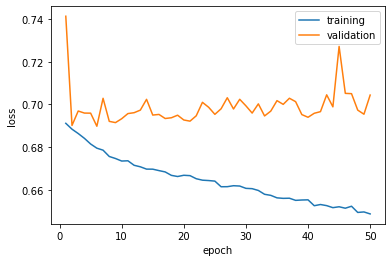

In [15]:
#model params defined in 1d

#split data
features = ["debt_assets", "de_ratio", "evm", "pe_exi",
               "roe", "npm","ps", "ptb", "pcf", "aftret_invcapx",
              "CPI", "PMI", "PPI", "FedFundsTargetRate", "GDP", 
              "MedianHomeSalesPrice", "PrivateHousingStarts","NonFarmPayrolls", "Unemployment",
            "MEDPTG", "PCTUP4W", "PCTDOWN4W", "volume",
             "return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

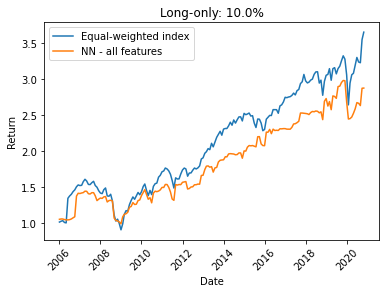

In [16]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d

returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets, cumrets = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

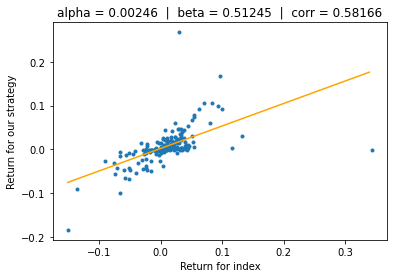

In [17]:
regression_analysis(np.array(rets_equal),np.array(rets))

In [18]:
#sharpe ratio
sharpe = calc_sharpe(rets)
print("NN sharpe: ", sharpe)

sharpe_equal = calc_sharpe(rets_equal)
print("Base index sharpe: ", sharpe_equal)

NN sharpe:  0.5242601558362786
Base index sharpe:  0.5715823672432059


In [19]:
#permutation importance
#importance,features_pi = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [20]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_28features_5layers_50epochs.h5


## 2b) Returns-only features

Training Set: 31190, Test Set: 103086 



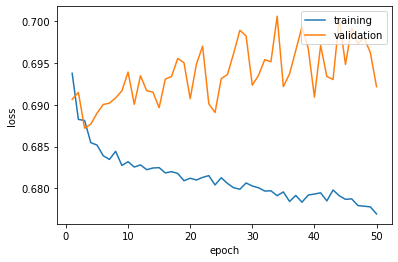

In [21]:
#model params defined in 1d

#split data
features = ["return_1M", "return_3M", "return_6M", "return_9M", "return_12M"]
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

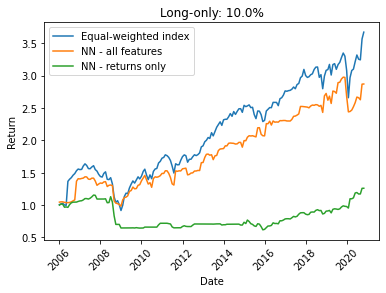

In [34]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_retonly, cumrets_retonly = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
plt.title("Long-only: " + str(pct*100) + "%");

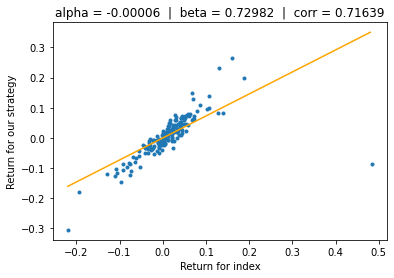

In [23]:
regression_analysis(np.array(rets_equal),np.array(rets_retonly))

In [24]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)

sharpe_retonly = calc_sharpe(rets_retonly)
print("NN sharpe, returns only: ", sharpe_retonly)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.5242601558362786
NN sharpe, returns only:  0.3196660865458206
Base index sharpe:  0.5715823672432059


In [25]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [26]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_5features_5layers_50epochs.h5


## 2c) Permutation Importance Features
- Only those with PI above 0
- and return features!

Training Set: 31190, Test Set: 103086 



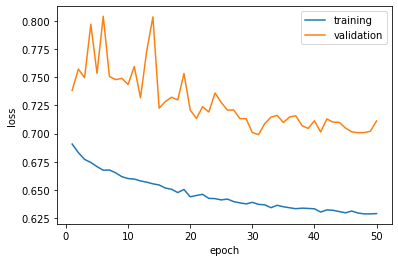

In [27]:
#model params defined in 1d

#split data
features = ['npm', 'aftret_invcapx', 'PMI', 'FedFundsTargetRate', 'GDP', 
            'PrivateHousingStarts', 'NonFarmPayrolls', 'Unemployment', 
            'MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M']
#features = ListUnion(features_pi,['MEDPTG', 'PCTDOWN4W', 'return_1M', 'return_9M', 'return_12M'])
target = "pred_target"
x_train, y_train, x_test, y_test = get_TrainTest(df_train,df_test,features, target, is_regression = is_regression)

#create model & train
model = create_NN(hidden, dropout, input_dim = len(features), is_regression = is_regression, std = 0.01, seed = seed)
#print(model.summary())
model, history = train_NN(model, x_train, y_train, x_test, y_test, learning_rate = learning_rate, is_regression = is_regression, num_epochs = num_epochs, plot_graph = True)

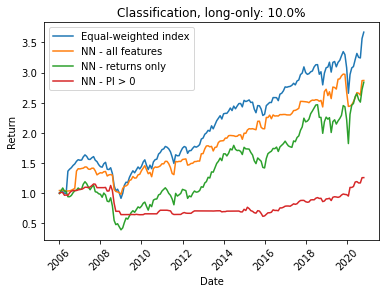

In [28]:
#calculate cost-adjusted returns & plot
#portfolio params defined in 1d
returns_matrix, weight_matrix, rank_table, model_output = get_Matrices(model, x_test, df_test, is_regression = is_regression, pct = pct, is_short = is_short, company_name = df_train.columns[0])
rets_pi, cumrets_pi = calc_returns(returns_matrix, weight_matrix = weight_matrix, k = k)

#calculate return & weight matrix for base strat - i.e. long 100%
returns_matrix_equal, weight_matrix_equal, rank_table_equal, model_output = get_Matrices(model, x_test, df_test,is_regression = is_regression, pct = 1, is_short = False, company_name = df_train.columns[0])
rets_equal, cumrets_equal = calc_returns(returns_matrix_equal, weight_matrix = weight_matrix_equal, k = k)

plt.plot(cumrets_equal.index, cumrets_equal, label = "Equal-weighted index")
plt.plot(cumrets.index, cumrets, label = "NN - all features")
plt.plot(cumrets_retonly.index, cumrets_retonly, label = "NN - returns only")
plt.plot(cumrets_pi.index, cumrets_pi, label = "NN - PI > 0")
plt.legend();
plt.xlabel("Date");
plt.xticks(rotation = 45);
plt.ylabel("Return")
if is_regression:
    title = "Regression"
else:
    title = "Classification"
if is_short:
    title = title + ", long-short: " + str(pct*100) + "%"
else:
    title = title + ", long-only: " + str(pct*100) + "%"
plt.title(title);

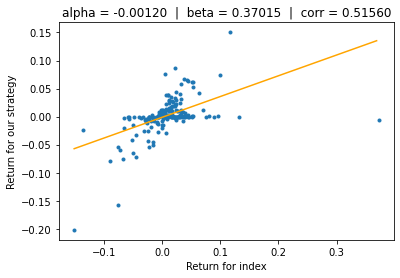

In [29]:
regression_analysis(np.array(rets_equal),np.array(rets_pi))

In [30]:
#sharpe ratio
print("NN sharpe, all features: ", sharpe)
print("NN sharpe, returns only: ", sharpe_retonly)

sharpe_pi = calc_sharpe(rets_pi)
print("NN sharpe, PI > 0: ", sharpe_pi)
print("Base index sharpe: ", sharpe_equal)

NN sharpe, all features:  0.5242601558362786
NN sharpe, returns only:  0.3196660865458206
NN sharpe, PI > 0:  0.13351323350389147
Base index sharpe:  0.5715823672432059


In [31]:
#permutation importance
#importance = feature_importance(model, x_test, y_test, features, n_repeats=5, random_state=seed, is_regression = is_regression)

In [32]:
# save model
if is_regression == True:
    label = "Models/NNreg_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"
else:
    label = "Models/NNclf_" + str(len(features)) + "features_" + str(len(hidden)) + "layers_" + str(num_epochs) + "epochs.h5"

model.save(label)
print("Model saved to: " + label)
#loaded_model = tf.keras.models.load_model(label, compile = False)

Model saved to: Models/NNclf_13features_5layers_50epochs.h5
